In [62]:
# This notebook is an attempt to train a neural net to recognize my handwriting.
#
# Currently this implementation can only detect a letter "k" between "k", "o" or "_". 
#
# The network is trained on positive samples "k" and negative samples "o".
#
# As far as I was experimenting, this does not work well if you train the network with more "negatives"
# (e.g. training for "k" which includes "_", "r", etc. ).
#
# It's good to note that the training data are only the inverse of the pixel intensity and the images are actually
# scaled down to have a smaller number of features. 
#
# Overall, I'm pretty sure this is not the proper way to go about this, but it's a fun thing to play with anyway. :-)

import numpy as np

# Represents a class for a specific recognition function.
class NeuralNet:    
  def __init__(self, name="NeuralNet"):
    self.name = name
    self._random_seed = 1
    self._synapses = []
        
  def _nonlin(self, x, deriv=False):
    if deriv:
      return x*(1-x)
    return 1/(1+np.exp(-x))

  def train(self, X, Y, iterations = 50000):
    np.random.seed(self._random_seed)
    
    # Initialize weights with random values.
    syn0 = 2 * np.random.random(X.shape[::-1]) - 1
    syn1 = 2 * np.random.random(Y.shape) - 1
    
    for j in xrange(iterations):
      # Feed forward through layers 0, 1, and 2
      l0 = X
      l1 = self._nonlin(np.dot(l0, syn0))
      l2 = self._nonlin(np.dot(l1, syn1))

      # how much did we miss the target value?
      l2_error = Y - l2

      if (j % 5000) == 0:
          print "Error:" + str(np.mean(np.abs(l2_error)))

      # in what direction is the target value?
      # were we really sure? if so, don't change too much.
      l2_delta = l2_error * self._nonlin(l2, deriv=True)

      # how much did each l1 value contribute to the l2 error (according to the weights)?
      l1_error = l2_delta.dot(syn1.T)

      # in what direction is the target l1?
      # were we really sure? if so, don't change too much.
      l1_delta = l1_error * self._nonlin(l1, deriv=True)

      syn1 += l1.T.dot(l2_delta)
      syn0 += l0.T.dot(l1_delta)
      self._synapses = [syn0, syn1]
 
  """ Output the probability of the input data being the letter the network was trained for"""
  def recognize(self, data):
    layer = data
    for syn in self._synapses:
       layer = self._nonlin(np.dot(layer, syn))
    
    return layer[0]


  

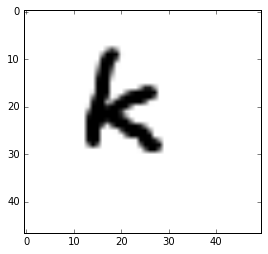

In [33]:
# Loading image
from io import BytesIO
from matplotlib import pyplot

%matplotlib inline

from PIL import Image
import os

training_data_dir = os.path.join(os.getcwd(), "handwriting", "training-data")

im = Image.open(os.path.join(training_data_dir, "k", "k0.png"))

def image_to_intensity(im):
  im.convert('LA')
  return [1 - np.average(color)/255 for color in list(im.getdata())]
  
# print image_to_intensity(im)

pyplot.imshow(np.asarray(im))





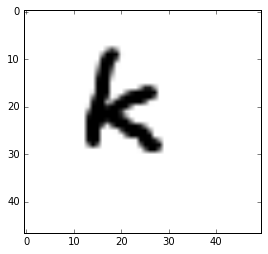

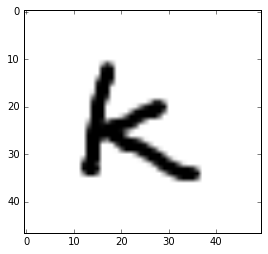

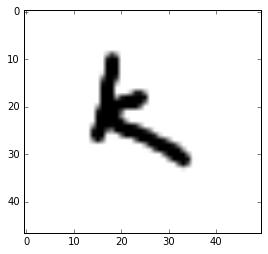

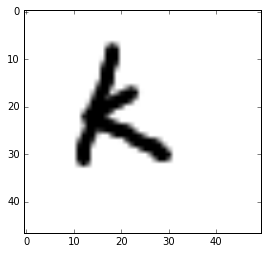

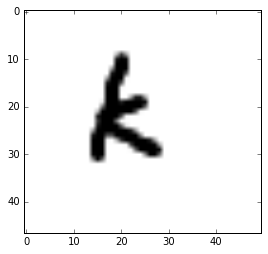

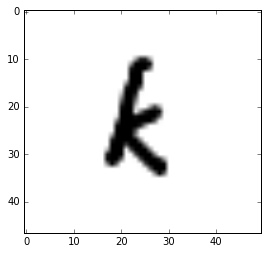

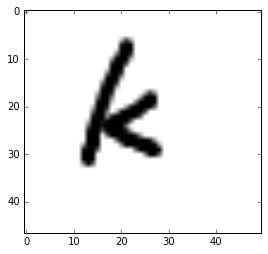

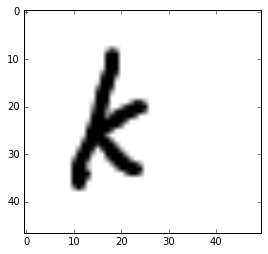

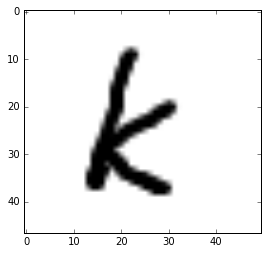

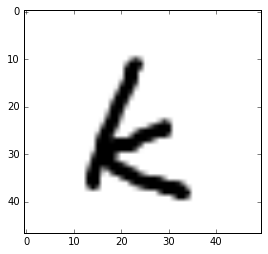

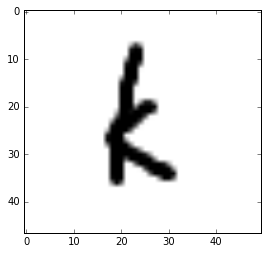

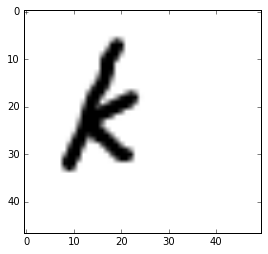

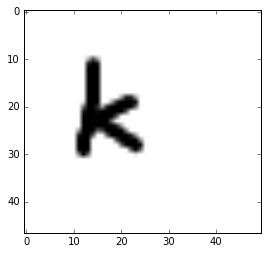

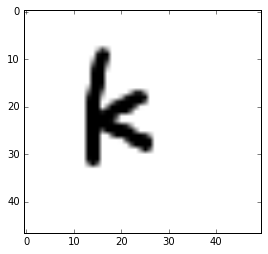

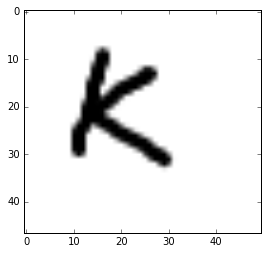

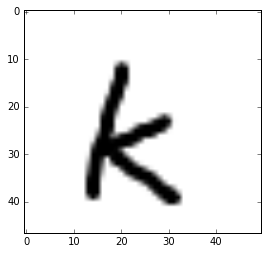

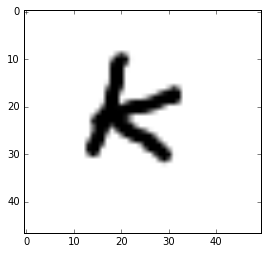

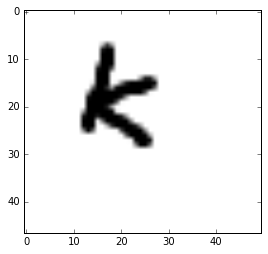

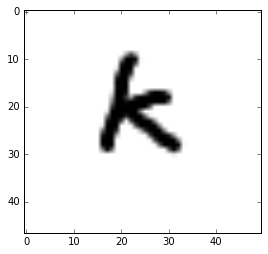

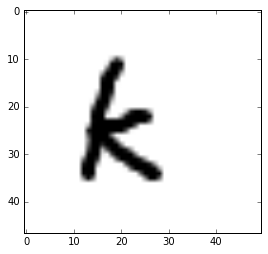

In [34]:
# Show all samples for a given letter
def get_handwriting_training_files(letter):
  directory = os.path.join(training_data_dir, letter)  
  for (dirpath, dirnames, filenames) in os.walk(directory):
    for filename in filenames:
      yield os.path.join(directory, filename)
  
list(get_handwriting_training_files("k"))

for filename in get_handwriting_training_files("k"):  
  im = Image.open(filename)
  pyplot.figure()
  pyplot.imshow(im)
  
  

In [35]:
# Load all samples of a letter to a format suitable for the neural network

def get_handwriting_training_data(letter):
   for filename in get_handwriting_training_files(letter):
      im = Image.open(filename)
      im.thumbnail((16,16), Image.ANTIALIAS)
      data = image_to_intensity(im)
      yield data
      

for sample in get_handwriting_training_data("k"):  
  print sample
  break
      
    

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0078431372549019329, 0.0078431372549019329, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0039215686274509665, 0.0, 0.207843137254902, 0.16078431372549018, 0.0, 0.0078431372549019329, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0039215686274509665, 0.031372549019607843, 0.86274509803921573, 0.28627450980392155, 0.011764705882352899, 0.011764705882352899, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0078431372549019329, 0.0, 0.19999999999999996, 0.83137254901960778, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011764705882352899, 0.0, 0.32549019607843133, 0.72549019607843135, 0.17647058823529416, 0.71372549019607845, 0.69019607843137254, 0.0078431372549019329, 0.0, 0.0039215686274509665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011764705882352899, 0.0, 0.58039215686274503, 0.92549019607843142, 0.83137254901960778, 0.4392156862745098, 0.17647058823

In [63]:
# Create a neural net for a single example
net_k = NeuralNet("k")

positive = get_handwriting_training_data("k")
negative = get_handwriting_training_data("o")

inputs = []
outputs = []
for sample in positive:
  inputs.append(sample)
  outputs.append([1])

for sample in negative:
  inputs.append(sample)
  outputs.append([0])

X = np.array(inputs)
Y = np.array(outputs)


print X.shape[::-1], Y.shape
net_k.train(X, Y)




(240L, 40L) (40L, 1L)
Error:0.457874619797
Error:0.000458762873074
Error:0.00033451443314
Error:0.000277405309664
Error:0.000242747699853
Error:0.00021882540914
Error:0.000201020685497
Error:0.000187093821065
Error:0.000175808701202
Error:0.0001664195697


In [167]:
def recognize(net, letter, max = 10, threshold = 0.2):
  i = 0
  print
  print "Recognizing letter", letter, "with neural-network ", net.name
  for new_sample in get_handwriting_training_data(letter):
    certainty = net_k.recognize(new_sample)
    print "%.2f" % (certainty*100), "%",
    
    if 1 - certainty < threshold:
      print "It's a", net.name
    elif certainty < threshold:
      print "It's something else"
    else:
      print "Not sure..."

    i += 1
    if i > max:
      break

recognize(net_k, "k-bold")
recognize(net_k, "o")
recognize(net_k, "o-bold")
recognize(net_k, "_")



Recognizing letter k-bold with neural-network  k
99.72 % It's a k
99.96 % It's a k
99.98 % It's a k
100.00 % It's a k
99.97 % It's a k
99.90 % It's a k
100.00 % It's a k
100.00 % It's a k
97.40 % It's a k
100.00 % It's a k
99.99 % It's a k

Recognizing letter o with neural-network  k
0.00 % It's something else
0.06 % It's something else
0.23 % It's something else
0.00 % It's something else
0.02 % It's something else
0.00 % It's something else
0.00 % It's something else
0.00 % It's something else
0.00 % It's something else
0.00 % It's something else
0.00 % It's something else

Recognizing letter o-bold with neural-network  k
99.19 % It's a k
27.92 % Not sure...
0.09 % It's something else
0.00 % It's something else
0.00 % It's something else
0.00 % It's something else
0.00 % It's something else
0.00 % It's something else
0.00 % It's something else
83.73 % It's a k
0.00 % It's something else

Recognizing letter _ with neural-network  k
0.00 % It's something else
0.00 % It's something els